Dados Sintéticos
=============
Convolve um espalhador com um refletor

---

In [1]:
from __future__ import print_function
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Importa bibliotecas próprias
from utils import * 

# Configura o matplolib para plotar inline
# %matplotlib qt5
# %matplotlib notebook
!python --version

Python 3.6.5 :: Anaconda, Inc.


---
Importa dado de reflexão migrado em tempo e respectivas estruturas

In [2]:
# Definição de arquivos de entrada
reflection_file = './reflexoes_migradas/solimoes_migrado.sgy'
edges_file = './estruturas/solimoes_edges.pickle'

color = 'seismic'
plot_bar = True
clip = 0.3

# Carrega dados de reflexão
if not reflection_file is None: 
    traces = load_traces(reflection_file)
    reflection_image = get_data_from_traces(traces)
    print("Dimensões do dado 1:", reflection_image.shape)
    print()
    
# Carrega arestas
edges = load_pickle(edges_file)['edges']
print("Estruturas:", edges.shape)



Carregando o empilhamento ./reflexoes_migradas/solimoes_migrado.sgy
2206 traços:
 - CDP: [17 - 2223]
 - Amostras por traço (ns): 751
 - Tempo entre amostras (dt): 4.0 ms
Dimensões do dado 1: (751, 2206)

Dados carregados de ./estruturas/solimoes_edges.pickle
 - edges
Estruturas: (751, 2206)


Tamanho da imagem (em polegadas): 30.64 x 10.43
Coordenadas:  x - [17.0, 2223.0], y - [0.0, 3.0]
Dimensão: (751, 2206)



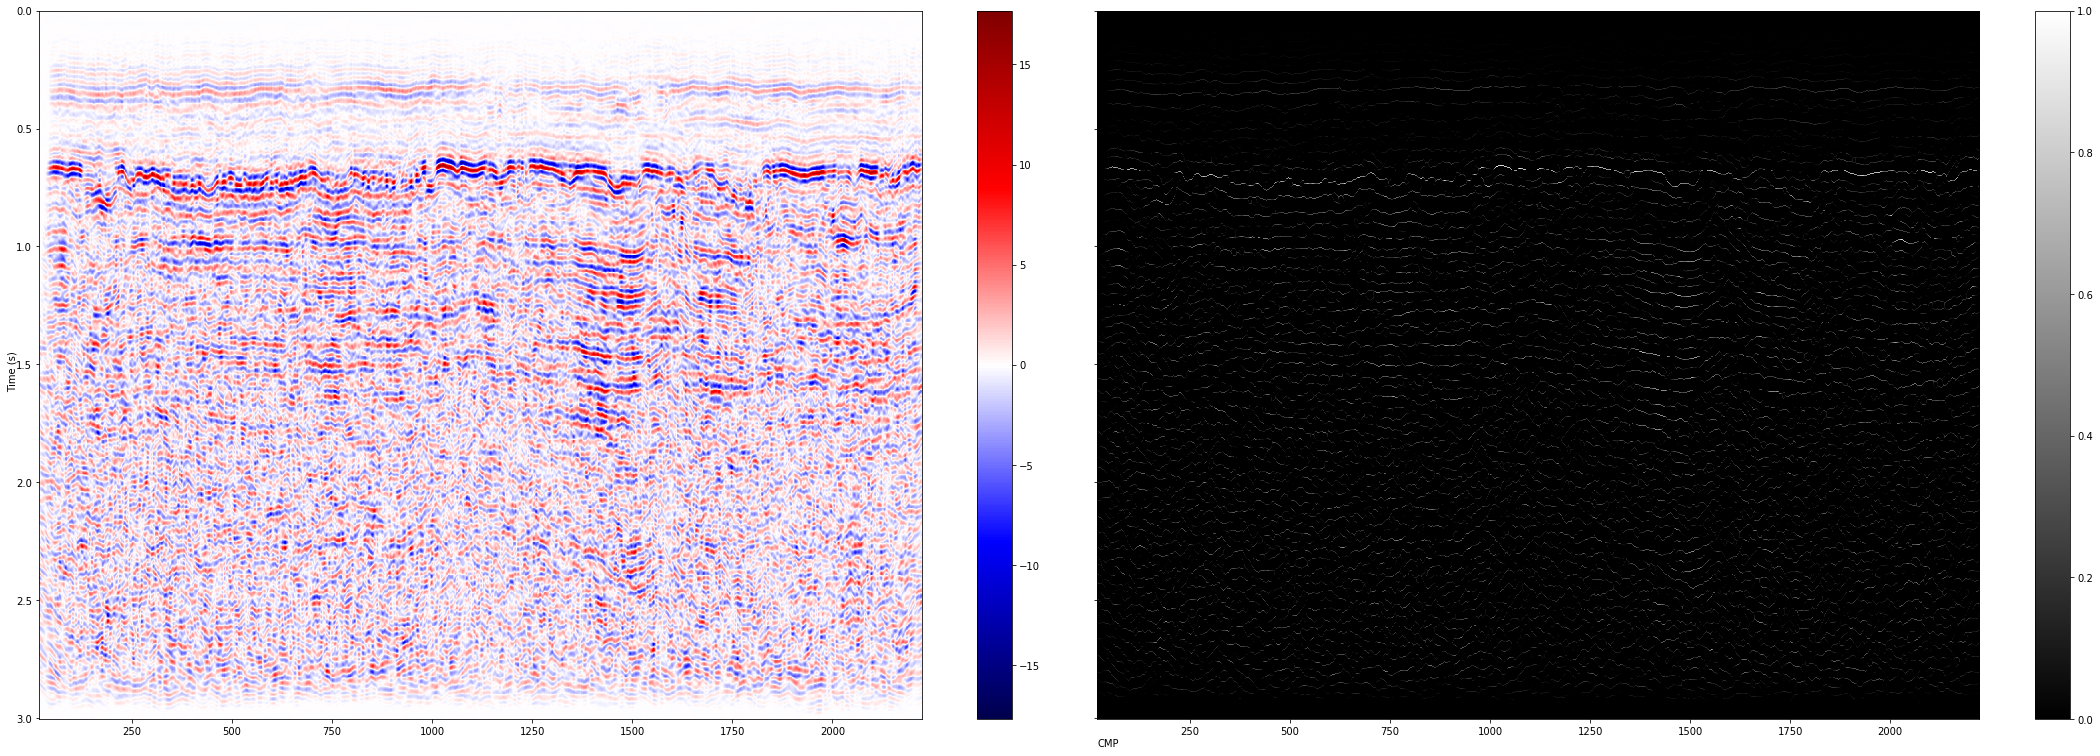

In [3]:
# Visualiza dados

color = 'seismic'
plot_bar = True
clip = 1.0

multiple_event_viewer(reflection_image, edges,
             cdp_offset=traces[0].cdp, dt=traces[0].dt,
             vmin2=0.0, vmax2=1.0, color2='gray',
             clip_percent1=clip, color1=color)

---
Importa PSFs e seleciona uma janela para gerar o dado

In [4]:
# Arquivo com PSFs
psf_file = './janelas/jequitinhonha.pickle'

data_dic = load_pickle(psf_file)
scatters = data_dic['scatters']
frequencies = data_dic['frequencies']
scatter_widths = data_dic['scatter_widths']

Dados carregados de ./janelas/jequitinhonha.pickle
 - scatter_widths
 - frequencies
 - scatters


Visualizando '' - 6 amostras


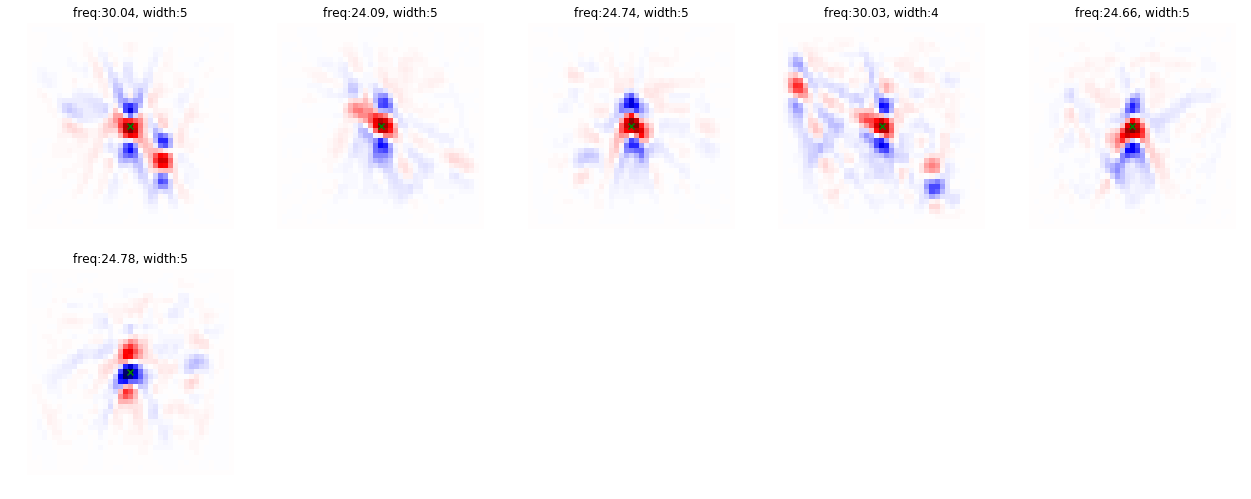

In [5]:
# Visualiza PSFs importados
max_samples = 30
color='seismic'
resize=3.5

# Cria título informativo para cada janela
labels = ['freq:%.2f, width:%d' % (f,w) for f,w in zip(frequencies, scatter_widths)]

if max_samples < scatters.shape[0]:
    num_samples = max_samples
else:
    num_samples = None
    
view_samples(scatters, labels, num_samples=num_samples, resize=resize, color=color)

Tamanho da imagem (em polegadas): 5.69 x 5.69
Coordenadas:  x - [0.0, 41.0], y - [0.0, 41.0]
Dimensão: (41, 41)



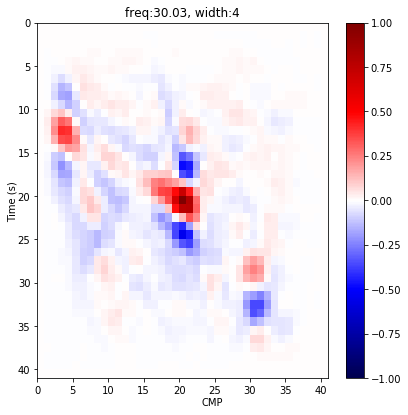

In [6]:
# Seleciona um PSF para convolver com o dado de estruturas
psf_index = 3
color='seismic'
resize=10.0

psf = scatters[psf_index]
psf_freq = frequencies[psf_index]
psf_width = scatter_widths[psf_index]

title = 'freq:%.2f, width:%d' % (psf_freq, psf_width)

multiple_event_viewer(psf, color1=color, resize=resize, title1=title)


---
Gera um 'ponto' a partir de uma wavelet de Ricker com a mesma frequência e largura que o PSF escolhido

In [7]:
taper_size = int(psf_width)
taper_size = 4
window_size = psf.shape[0]
dt = 0.004

# Constrói wavelet
wavelet = ricker_wavelet(psf_freq, window_size, dt)
# Constrói wavelet 2D
wavelet = wavelet.reshape((1,-1)).T
wavelet_2D = np.empty((window_size, taper_size*2+1), dtype=np.float32)
wavelet_2D[:,:] = wavelet
# Suaviza bordas aplicando função de taper
wavelet_2D = apply_taper(wavelet_2D, taper_size)
print("Wavelet_2D", wavelet_2D.shape)

Wavelet_2D (41, 9)


Tamanho da imagem (em polegadas): 5.69 x 5.69
Coordenadas:  x - [0.0, 41.0], y - [0.0, 0.2]
Dimensão: (41, 41)



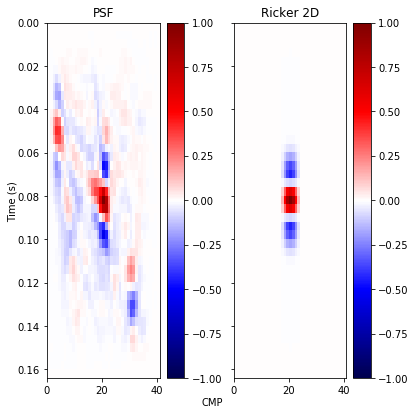

In [8]:
# Constrói janela para visualização equivalente ao PSF
color='seismic'
resize=10.0

title1='PSF'
title2='Ricker 2D'
    
center = window_size/2
wavelet_window = np.zeros(psf.shape)
wavelet_window[:, center-taper_size:center+(taper_size+1)] += wavelet_2D

multiple_event_viewer(psf, wavelet_window, resize=resize, color1=color, color2=color, dt=dt,
                     title1=title1, title2=title2)

---
Cria dados sintéticos convolvendo PSF, wavelet e wavelet 2D com o dado de bordas

In [9]:
noise = 0.1
background = (np.random.random(edges.shape) - 0.5) * noise
noisy_edges = background + edges

synthetic_psf = convolve2d(noisy_edges, psf, mode='same')
synthetic_ricker = convolve2d(noisy_edges, wavelet, mode='same')
synthetic_ricker2D = convolve2d(noisy_edges, wavelet_2D, mode='same')

Tamanho da imagem (em polegadas): 30.64 x 10.43
Coordenadas:  x - [0.0, 2206.0], y - [0.0, 751.0]
Dimensão: (751, 2206)



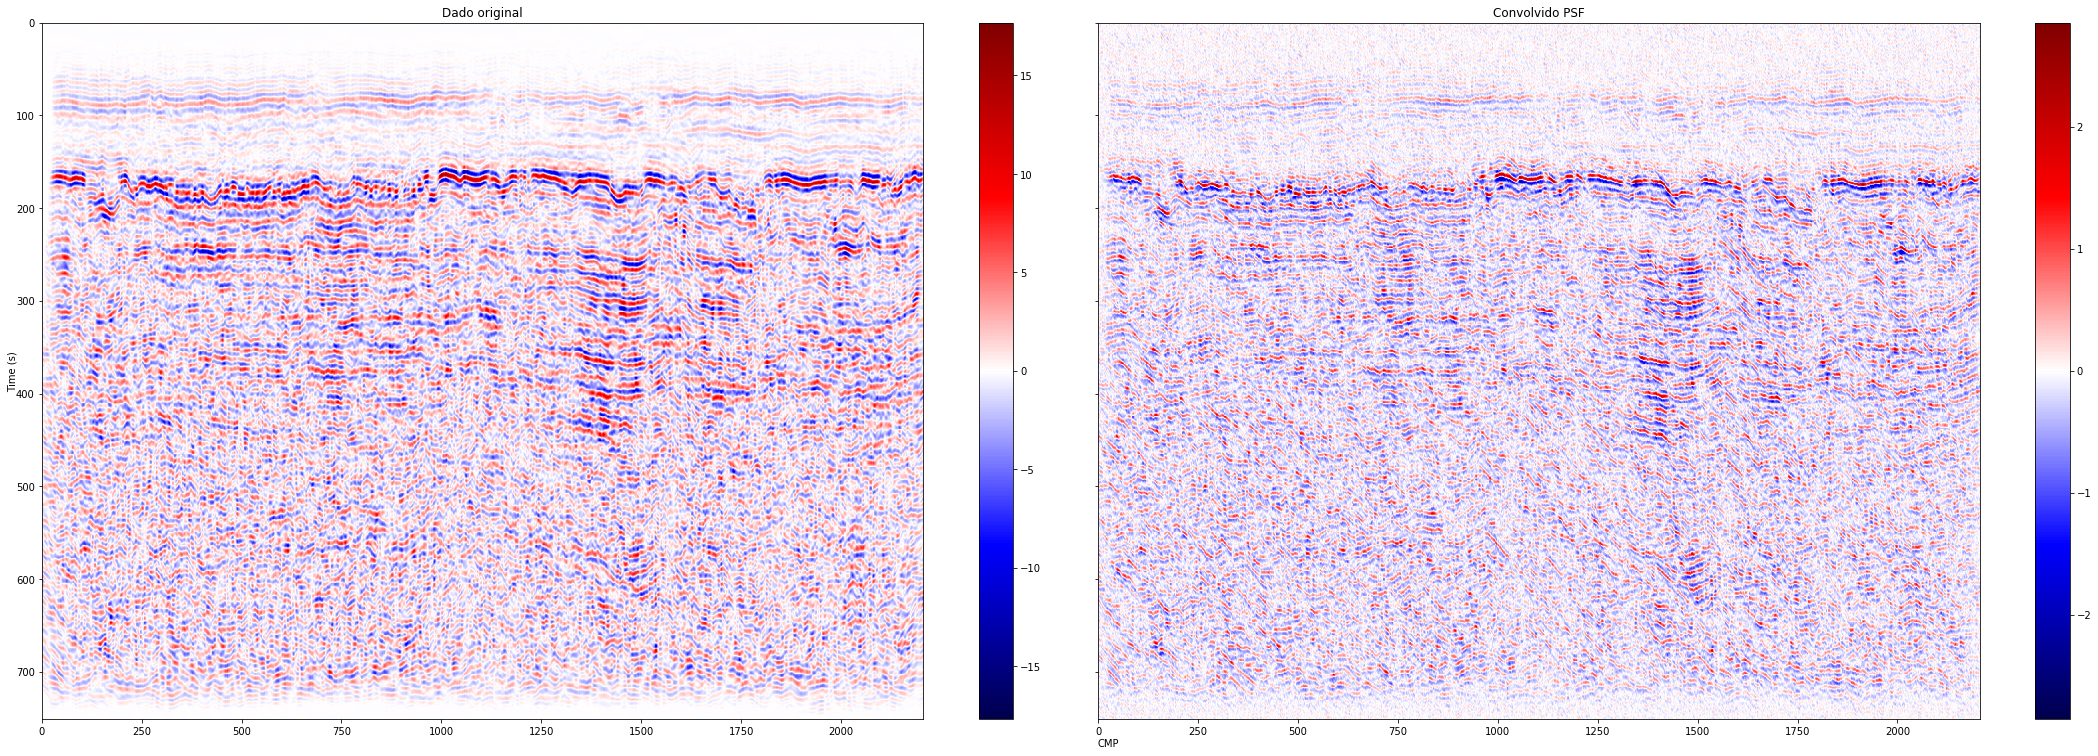

In [10]:
# Compara dado original com convolvido com PSF
color = 'seismic'
clip = 1.0

title1 = 'Dado original'
title2 = 'Convolvido PSF'

multiple_event_viewer(reflection_image, synthetic_psf,
                     color1=color, color2=color,
                     clip_percent1=clip, clip_percent2=clip,
                     title1=title1, title2=title2)

Tamanho da imagem (em polegadas): 30.64 x 10.43
Coordenadas:  x - [0.0, 2206.0], y - [0.0, 751.0]
Dimensão: (751, 2206)



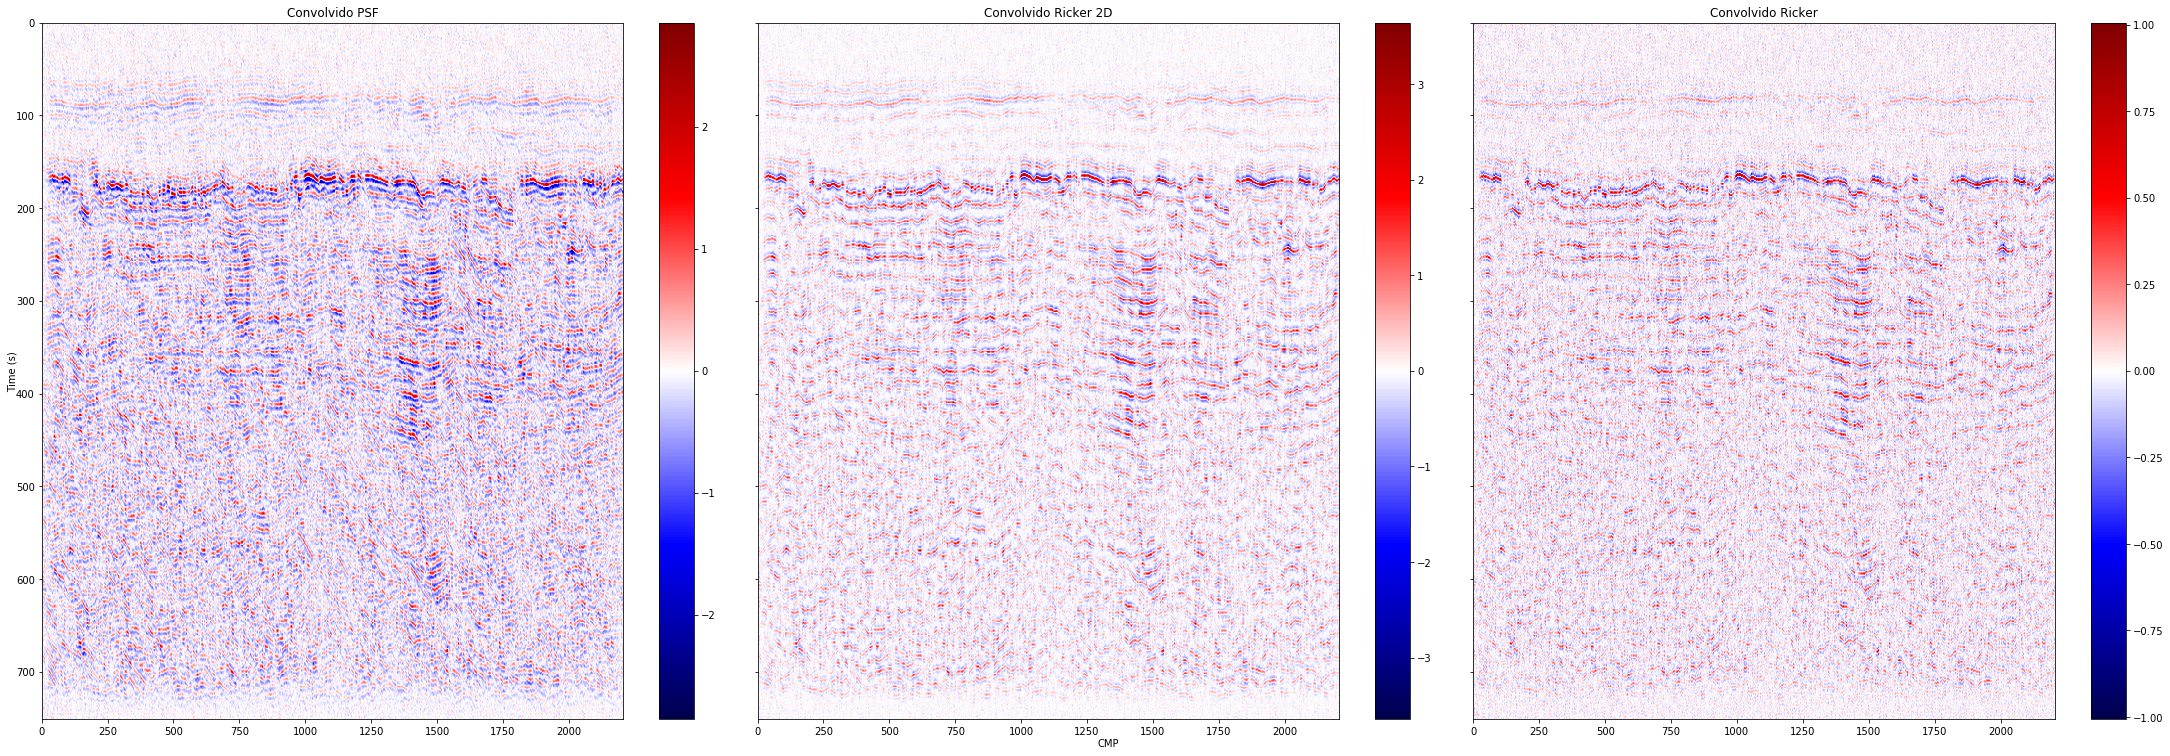

In [11]:
# Compara convolvido com PSF, wavelet e wavelet2D
title1 = 'Convolvido PSF'
title2 = 'Convolvido Ricker 2D'
title3 = 'Convolvido Ricker'

color = 'seismic'

multiple_event_viewer(synthetic_psf, synthetic_ricker2D, synthetic_ricker,
                     color1=color, color2=color, color3=color,
                     title1=title1, title2=title2, title3=title3)

Tamanho da imagem (em polegadas): 22.46 x 7.49
Coordenadas:  x - [1303.0, 1534.0], y - [1.5, 1.8]
Dimensão: (77, 231)



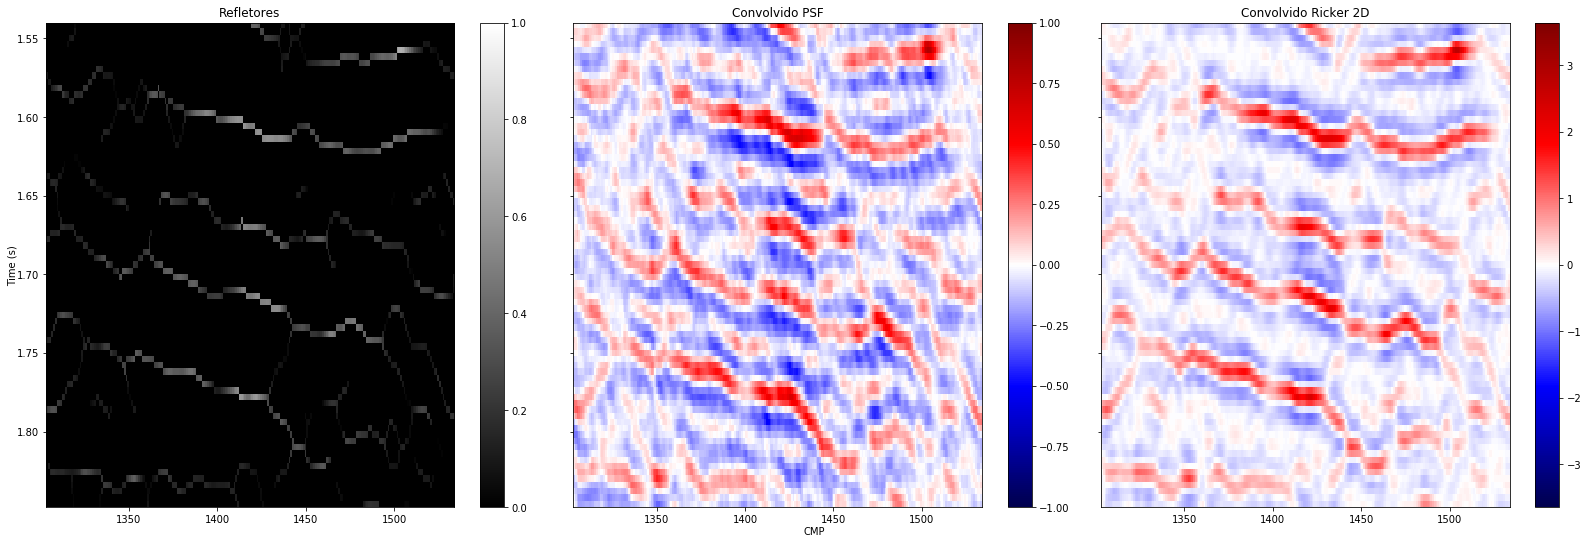

In [12]:
# Compara convolvido com PSF, wavelet e wavelet2D
title1 = 'Refletores'
title2 = 'Convolvido PSF'
title3 = 'Convolvido Ricker 2D'

color = 'seismic'

resize = 7.0

y_begin, x_begin = picks_to_index([(1303.835223, 1.540451)], traces)[0]
y_end, x_end = picks_to_index([(1534.616626, 1.849841)], traces)[0]

vmax = np.max(np.abs(synthetic_psf))
synthetic_psf /= vmax
vmax = np.max(np.abs(synthetic_ricker))
synthetic_ricker /= vmax

multiple_event_viewer(edges, synthetic_psf, synthetic_ricker2D,
                      x_begin=x_begin, x_end=x_end, y_begin=y_begin, y_end=y_end,
                      cdp_offset=traces[0].cdp, dt=traces[0].dt,
                     vmin1=0.0, vmax1=1.0,
                     resize=resize, color1='gray', color2=color, color3=color,
                     #bar1=False, bar2=False, bar3=False,
                     title1=title1, title2=title2, title3=title3)

In [13]:
noise = 0.1
background = (np.random.random(edges.shape) - 0.5) * noise
noisy_edges = background + edges

synthetic_psf = convolve2d(noisy_edges, psf, mode='same')
synthetic_ricker = convolve2d(noisy_edges, wavelet, mode='same')
synthetic_ricker2D = convolve2d(noisy_edges, wavelet_2D, mode='same')

In [25]:
import cv2

def show_img(img, color='gray', show_axis=False):
    
    fig, ax = plt.subplots() # fig = plt.figure()    
    if not show_axis: ax.axis("off")
    ax.imshow(img, cmap=color)
    plt.imsave("teste.png", img, cmap=color)
    # fig.set_size_inches(int(img.shape[0] / 4), int(img.shape[1]/4))
    fig.show()

def open_image(path, color_code=cv2.COLOR_BGR2RGB):
    return cv2.cvtColor(cv2.imread(path), color_code) 



In [76]:
def save_img(img, color='seismic'):
    print('Entrou aqui: ', img.shape, type(img), img.max(), img.min())
    plt.imsave("___Opaaaa3.png", img, cmap=color, vmin=-img.max(), vmax=img.max())
    return

img = open_image("../Code_Pix2Pix/results/seismic_pix2pix/test_latest/images/0_fake_B.png", cv2.COLOR_BGR2GRAY)
# print(type(img))
# vmin, vmax = img.min(), img.max() 
# img = (img - vmin) / float(vmax - vmin)
# img = (img * 2) - 1
# print(img.min(), img.max())
save_img(img, color='seismic')

Entrou aqui:  (256, 256) <type 'numpy.ndarray'> 248 18


In [ ]:
# show_img(synthetic_ricker2D, 'seismic')
save_img(synthetic_ricker2D, resize=1, color1='seismic', title1=title1)

In [16]:
import random

def make_sample():
    img_ref = np.zeros((256, 256))
    n_retas = random.randint(10, 15)

    for i in range(n_retas):
        x = random.randint(1, 127)
        y = random.randint(1, 255)
        size = random.randint(127, 255 - x)
        reta = np.ones((1, size))
        img_ref[y, x:x+size] = reta

    noise = 0.1
    img_back = (np.random.random(img_ref.shape) - 0.5) * noise
    noisy_img_ref = img_back + img_ref

    synthetic_psf = convolve2d(noisy_img_ref, psf, mode='same')
    synthetic_ricker2D = convolve2d(noisy_img_ref, wavelet_2D, mode='same')

    return synthetic_psf, synthetic_ricker2D

"""multiple_event_viewer(noisy_img_ref, synthetic_psf, synthetic_ricker2D, 
                      resize = 2.0, vmin1=0.0, vmax1=1.0, 
                      color1='gray', color2='seismic', color3='seismic', 
                      title1='Retas', title2='C PSF', title3='C Ricker')

"""

"multiple_event_viewer(noisy_img_ref, synthetic_psf, synthetic_ricker2D, \n                      resize = 2.0, vmin1=0.0, vmax1=1.0, \n                      color1='gray', color2='seismic', color3='seismic', \n                      title1='Retas', title2='C PSF', title3='C Ricker')\n\n"

In [58]:
def save_image(name, x, y):
    img = np.append(x, y, axis=1)
    vmin, vmax = img.min(), img.max() 
    img = (img - vmin) / (vmax - vmin)
    cv2.imwrite(name, img * 255)
    

def create_dataset(n_samples, pre_path='./../Code_Pix2Pix/datasets/seismic'):
    folders = ["train", "val", "test"]
    list_n_samples = [n_samples, int(n_samples * 0.2), int(n_samples * 0.2)]
    
    for j in range(3):
        print("Generating: ", folders[j])
        path = pre_path + "/" + folders[j]
        if not os.path.exists(path):
            os.mkdir(path)
        for i in range(list_n_samples[j]):
            x, y = make_sample()
            save_image(path + "/" + str(i) + ".jpg", x, y)   
            if (i  + 1) % 100 == 0:
                print("Percent: {0}%".format(int((i / n_samples) * 100)))

In [18]:
create_dataset(1000)

Generating:  train


KeyboardInterrupt: 

In [ ]:
int(None)